# Coursework 1 - Synfire chains

The aim of this coursework is to reproduce and extend the results of the following paper:

[Diesmann et al (1999) "Stable propagation of synchronous spiking in cortical neural networks"](https://www.nature.com/articles/990101) ([pdf](http://www.honda-ri.de/pubs/pdf/1406.pdf))

You can extend the code developed in the exercises in weeks 1 and 2.

You will need to read the paper, paying particular attention to the Methods section, to understand what the model is. As is often the case in older scientific papers, no code is provided and not all the details needed are given. You will need to think and experiment a bit to fill in the gaps.

You should submit your results as a Jupyter notebook that can be run on Google Colab. You should describe your code and results. Your code should be clear, and well commented, and your text should be clearly written and easy to follow. Remember, it will be assessed by 3 or more randomly selected individuals from the class. They will download and run your code, and if it does not work or they cannot understand it, you will get fewer marks.

A more detailed, step-by-step guide follows.

In [5]:
# These imports should be enough to do everything in this coursework, but feel free to use others
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import poisson, randint, seed
import math

## Task 1: implement a simulator for the model in the paper

Your simulator should have the following features:

1. Leaky integrate-and-fire neuron with alpha synapse acting on the current (note: not on the membrane potential). You should have two time constants, membrane time constant and alpha synapse time constant.
2. Background noise as a Poisson process (see notes below).
3. Refractoriness (see notes below).
4. Initialisation with an input spike burst as described in the paper.
5. All-to-all connectivity between layers. That is, each neuron in layer $i$ is connected to each neuron in layer $j$ (with the same weight).
6. Delay between layers (so a spike in layer $i$ takes a fixed amount of time before arriving in layer $i+1$).

You can build your simulator iteratively adding features as you verify the properties and reproduce the plots below. For task 2A, you only need feature (1). For task 2B you need features (1-3). For task 3 onwards you need all 6 features.

Recommended approach: try to solve task 2A first using only a simulator with feature (1). Now add features (2-3) and solve task 2B. Once you've finished that, go back and check your code still works for taks 2A. Continue like this.

### Poisson background noise

You can implement Poisson background noise by computing the mean number of expected noise spikes in any time step (product of sum of input firing rates and time step size), and then at each time step drawing a random, Poisson distributed value with this mean. You can the ``poisson`` function imported above to do this. Note that in this case there are two populations of neurons, one excitatory and one inhibitory.

### Refractoriness

After a spike, the neuron shuts down (membrane potential stays at reset value and incoming spikes are ignored) for a period of time called the refractory period. You can implement this by tracking, for each neuron, the last time it spiked, and only adding spikes for neurons which haven't fired within the refractory period.

### Suggested implementation

* A function that simulates a single layer of the network, taking the output spikes of the previous layer as an input argument, and returning its own output spikes.
* A function that generates spikes for an input burst in the same format as the input/output of the simulate layer function above.

In [522]:
def simulate_layer(num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=50):
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape
    
    ### Parameters
    dt = 0.1                    # time step in ms                   (outlined in paper)
    tau_m = 10.0                # membrane time constant in ms      (outlined in paper)
    tau_alpha = 0.378           # synaptic current time constant    (found experimentally)
    V_rest = -70.0              # resting potential in mV           (outlined in paper)
    V_thresh = -55.0            # spike threshold in mV             (outlined in paper)
    t_refractory_absolute = 1.0 # refractory period in ms           (outlined in paper)
    membrane_resistance = 4.17  # membrane resistance in ohms       (found experimentally)
    rand_synapse = 20000        # number of synapses per neuron     (outlined in paper)
    
    
    
    ### Setup the simulation
    v = np.full(num_neurons, fill_value=V_rest)     # Post Syntapic Potential
    x = np.zeros(num_neurons)                       # Post Synaptic current
    y = np.zeros(num_neurons)                       # Intermediate value for Post Synaptic Current
    t_last = np.full(num_neurons, fill_value=-1e9)  # Time of last spike for each neuron
    
    
    ### 6 - DELAY
    # If no spikes_in, fill array with 0
    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        # Add a delay to the spikes in (default is 5ms as outlined in paper)
        spikes_in = np.roll(spikes_in, shift=delay, axis=1)
        # np.roll has a wrap around feature, but this is not how we want it so we set all spikes that wrapped around to be 0
        spikes_in[:, :delay] = 0
    
    ### 2 - NOISE
    num_excitatory = (0.88 * rand_synapse)          # Since 88% of synapses are excitatory
    num_inhibitory = rand_synapse - num_excitatory  # Other 12% are inhibitory
    
    # background noise parameters
    exc_rate = 2.0      # excitatory firing rate in Hz
    inh_rate = 12.5     # inhibitory firing rate in Hz
    
    if noise:
        # Initialise voltages randomly between threshold and rest potential in order to mimic paper
        v = np.random.uniform(-70, -55, num_neurons)
        # Find the mean number of excitatory and inhibitory neurons firing at each timestep
        mean_excitatory = exc_rate * (dt/1000) * num_excitatory
        mean_inhibitory = inh_rate * (dt/1000) * num_inhibitory
        for t_idx in range(num_time_steps):
            # Using a poisson distribution, assign every timestep a number of excitatory and inhibitory neurons that will fire at that timestep
            noise_spikes_excitatory = np.random.poisson(mean_excitatory, num_neurons)
            noise_spikes_inhibitory = np.random.poisson(mean_inhibitory, num_neurons)
            # Add this noise onto the spikes going into the network, since neurons can't differentiate between noise and actual spikes
            # Since all synapses are weighted equally, we simply add for excitatory and minus for inhibitory
            spikes_in[:, t_idx] += noise_spikes_excitatory
            spikes_in[:, t_idx] -= noise_spikes_inhibitory

        
    # Initialise to record values of recorded output voltage and output spikes
    V_rec = np.zeros((num_neurons, num_time_steps))
    spikes_out = np.zeros((num_neurons, num_time_steps))
    
    
    
    ### Run simulation
    for t_idx in range(num_time_steps):

        t = t_idx * dt
        
        ### 3 - IMPLEMENTING REFRACTORINESS (Only absolute refractoriness as mentioned in notes above)
        # Absolute refractoriness
        # Determine which neurons are in the absolute refractory period
        refractory_neurons = (t - t_last) < t_refractory_absolute
        # Set neurons which are in refractory period to rest
        v[refractory_neurons] = V_rest
        # Don't allow any spikes in whilst in refractory period
        spikes_in[refractory_neurons, t_idx] = 0

        
        ### 1 - DIFFERENTIAL EQUATIONS (LIF WITH ALPHA SYNAPSE)
        # Update alpha synapse current differential equation
        dx_dt = (y - x) / tau_alpha 
        # Update intermediate value, y, differential equation
        dy_dt = - y / tau_alpha 
        # Update alpha synapse current
        x += dx_dt*dt
        # Update intermediate value, y
        # Spikes immediately change the value of intermediate value y, as per alpha synapse
        y += dy_dt*dt + spikes_in[:, t_idx]
        # Update membrane potential differential equation
        dv_dt = (membrane_resistance * x + V_rest - v)/tau_m
        # Update membrane potential
        v += dv_dt * dt
        

        
        # Handle Spiking
        # Creates an array of 1's and 0's corresponding to whether each neuron has spiked in this timestep or not 
        spiked_neurons = v >= V_thresh
        # Set all spiked neurons back to resting potential
        v[spiked_neurons] = V_rest
        # Assign the last time each neuron has spiked to this timestep if they have spiked
        t_last[spiked_neurons] = t
        
        
        # We considered implementing a floor function so that voltage potentials could not go below -70mV, 
        # however as we see from biology it is possible to go below resting potential, and since there was no mention in the paper, we decided to leave it out
        # below_rest = v < -70
        # v[below_rest] = -70
        
        
        # Record output of voltage and when spikes occur
        V_rec[:, t_idx] = v
        spikes_out[:, t_idx] = spiked_neurons

    return V_rec, spikes_out

# 4 - INITIAL INPUT BURST
def input_burst(num_neurons=100, num_active=50, offset=0, sigma=0, num_time_steps=700, dt=0.1):
    # Convert sigma from ms to timesteps by dividing by dt
    sigma = sigma/dt
    # Initialise spikes array and fill with zeros
    spikes = np.zeros((num_neurons, num_time_steps))
    
    # Out of the total num_neurons, randomly select num_active of them to spike
    spiking_neurons = np.random.choice(num_neurons, num_active, replace=False)
    
    # Normally distribute the input spikes arround the time they are meant to come in according to input variation, sigma
    spike_time_distribution = np.random.normal(loc=offset, scale=sigma, size=int(num_active)).astype(int)

    neuron_index = 0
    # Assign a 1 to each neuron which spikes (determined by spiking_neurons), and for the time at which it spikes (determined by spike_time_distribution)
    for spike_time in spike_time_distribution:
        if 0 <= spike_time < num_time_steps:
            spikes[spiking_neurons[neuron_index], spike_time] = 1
        neuron_index +=1
    return spikes

# 5 - ALL TO ALL CONNECTIVITY
# Sums spikes from all neurons into one (or more) array indexed by time
# then feeding that into next layer means all spikes from previous layer will go to all spikes in next layer
def all_to_all(spikes, n_out=None):
    s = spikes.sum(axis=0)[None, :]
    if n_out is None:
        n_out = spikes.shape[0]
    return np.repeat(s, n_out, axis=0)

## Task 2: validate neuron, synapse and network properties

### Task 2A: validate postsynaptic potential

Write down the differential equations for your model.

Verify that you have implemented the neuron and synapse model correctly by feeding it a single input spike, plotting the membrane potential (postsynaptic potential, PSP) and checking that the time to peak, and peak value are as given in the paper. It doesn't have to be absolutely perfect, just close enough.

____________
____________

The Alpha-synapse model gives:

<div style="text-align:center">

$ x(t)$ $= H(t)e^{-\frac{t}{\tau_{x}}} \frac{t}{\tau_{x}}$ &nbsp; _(1)_

</div>

&nbsp;&nbsp;&nbsp;&nbsp; where $x$ is the Post-Synaptic Current, $\tau_{x}$ is the Alpha-synapse time constant and $H(t)$ denotes the Heaviside function.

<br>

The Post-Synaptic Potential of a LIF neuron with synapses can also be modelled with the differential equation:

<div style="text-align:center">

$ \tau_{m}v' = Rx - v$ &nbsp; _(2)_

</div>

&nbsp;&nbsp;&nbsp;&nbsp; where $v$ is the Post-Synaptic Potential, $\tau_{m}$ is the membrane time constant and $R$ is the membrane resistance.


<br>


From _(1)_, we get the 2 differential equations:

<div style="text-align:center">

$ \tau_{x}y' = -y$ &nbsp; _(3)_

$ \tau_{x}x' = y - x$ &nbsp; _(4)_

</div>

&nbsp;&nbsp;&nbsp;&nbsp; where $y$ is an intermediate variable to represent the Post-Synaptic Current, $x$.

<br>

&nbsp;&nbsp;&nbsp;&nbsp; The solution to _(3)_ is given by:

<div style="text-align:center">

$ y(t) = y(0) e^{-\frac{t}{\tau_{x}}}$ &nbsp; _(5)_

</div>

&nbsp;&nbsp;&nbsp;&nbsp; The solution to _(4)_ is given by:

<div style="text-align:center">

$ x(t) = x(0)e^{-\frac{t}{\tau_{x}}} + (1-e^{-\frac{t}{\tau_{x}}})y(t)$ &nbsp; _(6)_

</div>

<br>

Also solving for _(2)_, we get the solution given by:

<div style="text-align:center">

$ v(t) = v(0) e^{-\frac{t}{\tau_{m}}} + (1 - e^{-\frac{t}{\tau_{m}}}) R x(t)$ &nbsp; _(7)_

</div>

<br>
<br>

<div style="text-align:center">

The equations _(5), _(6)_ and _(7)__ allow for the implementation of our LIF neuron's model with an Alpha-synapse. 

</div>

Alpha PSP verification
  Maximum of PSP is -69.8628 and should be -69.86
  Maximum is attained at time 1.70 and should be 1.70



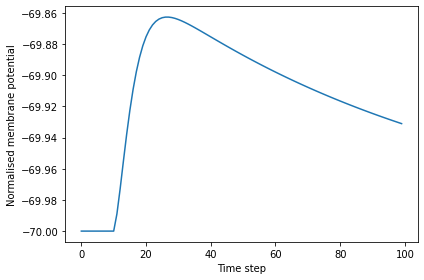

In [544]:
# Verify synapse properties with no background noise and single input spike
s_in = np.zeros((1, 100)) # duration 10ms
s_in[0, 10] = 1 # single input spike at time t=1ms
v, s = simulate_layer(spikes_in=s_in, noise=False, delay=0)
plt.figure()
plt.plot(v[0, :])
plt.xlabel('Time step')
plt.ylabel('Normalised membrane potential')
plt.tight_layout();
print('Alpha PSP verification')
print(f'  Maximum of PSP is {v.max():.4f} and should be -69.86') # what is the correct value for ...?
print(f'  Maximum is attained at time {(v.argmax()-10)*0.1:.2f} and should be 1.70') # what is the correct value for ...?
print()

Expected results:

![Expected results](result_2a.png)

### Task 2B: validate background noise

Verify that in the absence of any input spikes, neurons in the network fire noise spikes at approximately the rate given in the paper, and that the mean and standard deviation of the membrane potential is as given in the paper. Plot the output spikes and 5 membrane potentials to check that the results seem sensible.

Background firing rate verification
  Mean rate is 2.2 Hz, should be approximately 2 Hz
  Membrane potential mean is -62.29 so (7.71 above -70mV), should be approximately -61.75 mV (8.75 mV above -70 mV)
  Membrane potential std is 2.90, should be approximately 2.85 mV


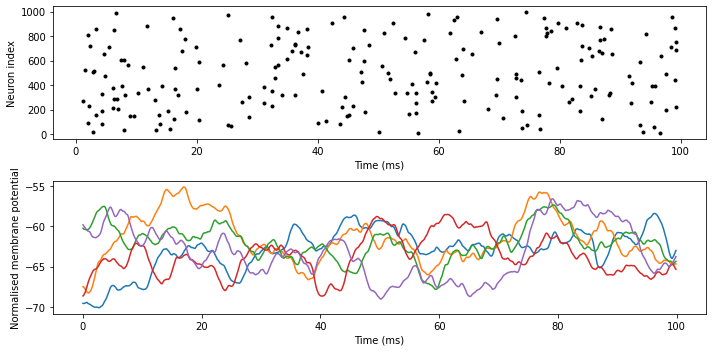

In [546]:
# Verify background noise gives appropriate level of output noise
v, s = simulate_layer(num_neurons=1000, num_time_steps=1000)
i, t = s.nonzero()
t = t*0.1 # dt
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(t, i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(212)
plt.plot(np.arange(1000)*0.1, v[:5, :1000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()
print('Background firing rate verification')
# TODO: Fill in the ... values below
print(f'  Mean rate is {s.sum() / (1000 * 1000 * 0.1 * 1e-3):.1f} Hz, should be approximately 2 Hz')
print(f'  Membrane potential mean is {v.mean():.2f} so ({v.mean()+70 :.2f} above -70mV), should be approximately -61.75 mV (8.75 mV above -70 mV)')
print(f'  Membrane potential std is {v.std():.2f}, should be approximately 2.85 mV')

Expected results:

![Expected results](results_2b.png)

## Task 3: reproduce figures 1d and 1e from the paper

The plotting doesn't have to be perfect, but it should be recognisably similar to the paper.

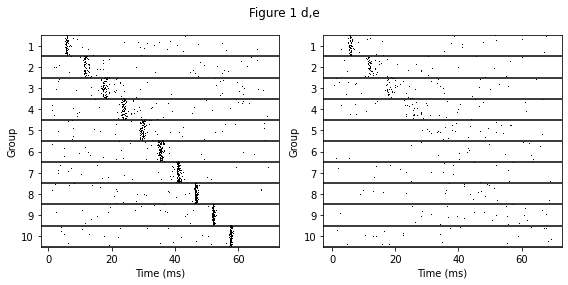

In [553]:
# Verify figure 1d,e
# 100 neurons as per paper
num_neurons = 100
plt.figure(figsize=(8, 4))
# a - the number of active neurons, is from paper
a_values = [50, 48]
# Paper - synaptic delay arbitrarily set to 5ms, so thats 5*10 = 50 timesteps of delay
delay = 50


for plotidx, a in enumerate(a_values):
    # Sigma is 0 as per paper which says input standard deviation for both graphs is 0
    s = input_burst(num_neurons=num_neurons, sigma=0, num_active=a, offset=0)

    plt.subplot(1, 2, plotidx+1)
    
    
    for layer in range(10):
        s_accumulated = all_to_all(s)      
        max_values = []
        temp_s = []
        # Due to the random nature of the way in which this task is set, and since we are meant to use the same initial spike values as in the paper, 
        # 50 and 48 which are relatively very close, it is hard to get the figure outlined in the paper on every single run.
        # The paper mentions that the reason the figures below are distinct is:
        
        # "The degree of temporal accuracy of spike times among the group's members determines whether subsequent groups can reproduce (or even improve) this accuracy (Fig. 1d), 
        # or whether synchronous excitation disperses and eventually dies out (Fig. 1e)."
        
        # This temporal accuracy is random, due to noise. 
        # We had an implementation which adjusted the temporal accuracy by passing spikes to each next layer with a normal distribution for spike times with sigma > 0 (NOT in input burst function, because paper explicitly stated that input standard deviation is 0).
        # This means there was a % chance spikes would happen in different time frames than they meant to (hence less temporal accuracy).
        # However we thought this might be disengenuous, since the paper is trying to tell us that it is from randomness.
        # So in order to make sure that we 'usually' produced the figure, we did not edit the actual spikes or their distribution at all, but simply ran the layer multiple times, and taking the best results from them
        # If the reader would like to see the results without this modification, simply comment out next lines 
        # ===============================================================================================================================================================================
        if plotidx == 0:
            for i in range(5):
                _, s = simulate_layer(spikes_in=s_accumulated)
                max_values.append(np.sum(all_to_all(s, n_out=1)))
                # Find the maximum value in the list
                max_value = max(max_values)
                temp_s.append(s)

            # Find the index of the maximum value
            max_index = max_values.index(max_value)
            s = temp_s[max_index]
        else:
            _, s = simulate_layer(spikes_in=s_accumulated)
        # ===============================================================================================================================================================================
        # and uncomment this: (you will need to run it a few times to see the result from the paper, which is the reason why we automated that above)
        # _, s = simulate_layer(spikes_in=s_accumulated) 
        i, t = s.nonzero()
        plt.plot(t*0.1, i/100+9-layer, ',k')
        plt.axhline(layer, c='k')
    plt.ylim(0, 10)
    plt.yticks(np.arange(10)+0.5, np.arange(1, 11)[::-1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Group')
plt.suptitle('Figure 1 d,e')
plt.tight_layout();

Since there is randomness involved with this, this is one of the 'good' images we produced (with proper method):

![Our results](Q3_output_good.png)

Expected results (may not be exactly the same each time you run):

![Expected results](result_3.png)

## Task 4: reproduce figures 2c and 2d

In this case, the paper is lacking a lot of detail in how to estimate the probability and spread of an output spike. You are unlikely to be able to perfectly reproduce the output, but you should be able to get something similar and justify your results, or explain why you think the paper got it wrong if you disagree.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


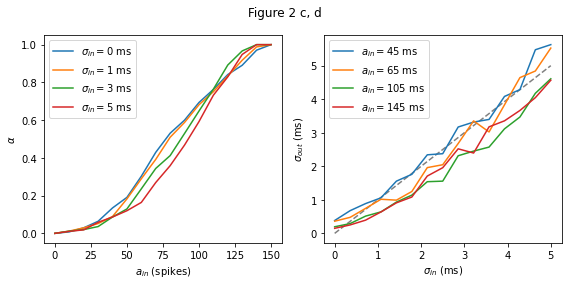

In [530]:
# Verify figure 2c,d
def estimate_pulse_parameters(s, num_neurons, sigma_in, offset): # you can change the arguments to this function if you need
    # Now we want to estimate the number of spikes caused and their spread.
    # alpha = probability of an output spike = number of output spikes / number of neurons
    # sigma_out = spread (in ms) of output spikes caused by the pulse
    dt = 0.1
    # Use all _to_all on the transpose of s. This is to sum the row instead of the columns.
    # This will then tell us which neurons have spiked at anytime
    neuron_which_spiked_array = (all_to_all(np.transpose(s), n_out=1))
    # Sum these neurons to find total neurons spiked
    sum = np.sum(neuron_which_spiked_array)
    # Make sure the sum doesn't exceed the number of neurons
    if sum > num_neurons:
        sum = num_neurons
    # Make sure we dont get divide by 0 error - if there are no neurons then 0 will spike
    if num_neurons == 0:
        alpha = 0
    else:  
        alpha = sum / num_neurons
    # Find all instances where there was a spike
    _, timestamps = s.nonzero()
    # Sort these timesatmps in order, so we can find outliers in noise
    sorted_timestamps = np.sort(timestamps)
    # If no spikes, therefore standard deviation = 0
    if sorted_timestamps.size == 0:
        sigma_out = 0
    else:
        # Filter out the outliers
        # At low spike in amounts, most of the spikes will be due to noise. 
        # This wont give us accurate estimations of the standard deviation of our burst.
        # Especially for low input standard deviation, because this means that when standard deviation = 0, 
        # the noise will drag out the standard deviation very far out
        
        # To alleviate this problem we filter out the outliers of the data
        # Since we dont actually know which spikes are purely noise and which are (noise + input burst), we used a statistical aproach to find the standard deviation.
        # The 68–95–99.7 rule states that within 1 standard deviation of mean 68% of results are found, for 2, 95%, and for 3 99.7%
        # This gave us a cutoff between 2 and 3 standard deviations of the mean where almost all real results are taken, and most noise is filtered out
        # This works great for larger standard deviation, but for standard deviation of 0, this means we wouldn't be able to see if the standard deviation has changed at all
        # since all other results are filtered out
        
        # We therefore added a 20 timestep gap around the mean so that changes for low input standard deviations could be observed
        # Since we added this buffer of 20, we thought that 2.5 standard deviations with the 20 timestep buffer is sufficient enough to filter out noise, and capture almost all real data
        # We divide sigma by dt, since sigma is in ms, but the array is broken down by timestamp not ms, so we divide by dt
        filtered_array = sorted_timestamps[(sorted_timestamps <= 20 + offset + (sigma_in/dt)*2.5) & (sorted_timestamps >= offset - 20 - (sigma_in/dt)*2.5)]

        # Calculate the standard deviation of the remaining data
        sigma_out = (np.std(filtered_array))/10
    
    return alpha, sigma_out

def neural_transmission(a_in, sigma_in, repeats=5, dt=0.1):
    alpha_sum = 0
    sigma_out_sum = 0
    # We include an offset of 15ms, so that if even for a sigma_in of 5ms, 99.7% (3 sigma rule) of results will happen in the given timeframe
    # This is because we don't want any spikes happening in a negative timestep, so those will be cut off.
    # So in order to minimise the effect from cutting out those few outliers, we give the input burst a lot of space
    offset = 150
    # Similar to above. If burst is in time 15ms, then a total time of 40 ms means even with delay, >99.7% of results will be captured
    num_time_steps = 400
    # Since maximum number of neurons which can spike initially is 150, and at max, 100% will spikes in total, there are 150 total neurons
    num_neurons = 150
    # Repeat this process and take the average results to smooth out curve for less noise
    for i in range(repeats):
        # We put in a burst of a_in spikes with spread sigma_in
        s = input_burst(num_neurons=a_in, num_active=a_in, offset= offset, sigma=(sigma_in), dt=dt, num_time_steps=num_time_steps)
        # Connect input burst to all neurons in next layer
        s = all_to_all(s)
        # Run the simulation for one layer
        _, s = simulate_layer(num_neurons=num_neurons, spikes_in=s, noise=True, num_time_steps=num_time_steps, delay=0)
        # Add alpha and sigma_out to temporary values in order to get their average and smooth out the noise
        alpha_temp, sigma_out_temp = estimate_pulse_parameters(s, num_neurons, sigma_in, offset)
        alpha_sum += alpha_temp
        sigma_out_sum += sigma_out_temp
    # Divide by number of repeats to find average alpha and sigma_out
    alpha = alpha_sum/repeats
    sigma_out = sigma_out_sum/repeats
    return alpha, sigma_out

plt.figure(figsize=(8, 4))
plt.subplot(121)
for sigma in [0, 1, 3, 5]:
    A_IN = np.arange(0, 150+1, 10)
    ALPHA = [neural_transmission(a_in, sigma)[0] for a_in in A_IN]
    plt.plot(A_IN, ALPHA, label=f'$\\sigma_{{in}}={sigma}$ ms')
plt.xlabel(r'$a_{in}$ (spikes)')
plt.ylabel(r'$\alpha$')
plt.legend(loc='best')
plt.subplot(122)
for a_in in [45, 65, 105, 145]:
    SIGMA_IN = np.linspace(0, 5, 15)
    SIGMA_OUT = [neural_transmission(a_in, sigma_in)[1] for sigma_in in SIGMA_IN]
    plt.plot(SIGMA_IN, SIGMA_OUT, label=f'$a_{{in}}={a_in}$ ms')
plt.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
plt.xlabel(r'$\sigma_{in}$ (ms)')
plt.ylabel(r'$\sigma_{out}$ (ms)')
plt.legend(loc='best')
plt.suptitle('Figure 2 c, d')
plt.tight_layout();

Expected results (as you can see, not exactly the same as in the paper which I couldn't reproduce perfectly):

![Expected results](result_4.png)

## Task 5: reproduce figure 3c

It is sufficient to plot some of the trajectories, and not the separatrix (dashed line).

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Figure 3c')

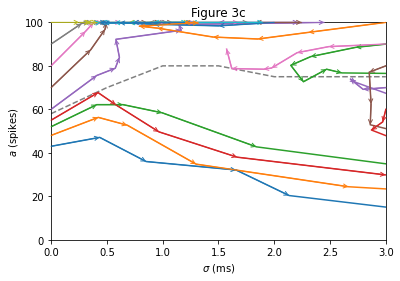

In [531]:
# We choose starting points (based on the paper's choice of starting points) on the borders of the (a, sigma) state-space so as to initialise pulse packets.
starting_points = [
    (43, 0), (48, 0), (52, 0), (55, 0), (60, 0), (70, 0), (80, 0), (90, 0), (100, 0), (100, 1), (100, 2), (100, 3), (90, 3), (60, 3), (70, 3), (80, 3), (90, 3)
    ]

repeats = 20        # Number of times to repeat the calculation in order to average out runs and get a smoother trajectory (negating noise impact)
dt = 0.1            # Time step
num_neurons = 100   # As outlined in the paper
offset = 100        # We include an offset of 10ms, so that, even for a sigma_in of 3ms, >99.7% of results will happen in the given timeframe
                        # This is because we dont want any spikes happening in a negative timestep, so those will be cut off.
                        # So in order to minimise the effect from cutting out those few outliers, we give the input burst a lot of space.


for idx, (a, sigma) in enumerate(starting_points):
    A, SIGMA = [a], [sigma]
    # We apply an input burst to a pulse packet characterising a spike volley
    # by choosing a portion (a) of the total number of neurons to spike
    s = input_burst(num_neurons=num_neurons, num_active=a, offset = offset, sigma=sigma, dt=dt, num_time_steps=400)
    
    # The evolution of (a, sigma) is done through 10 iterations:
    for _ in range(10):
        
        # Recording (a, sigma) values to plot:
        A.append(a)
        SIGMA.append(sigma)

        # Variables to use for finding the mean values for a and sigma:
        a_sum = 0
        sigma_sum = 0

        # Running the calculation for the new values of (a, sigma) repeatedly to find the mean (negating noise impact)
        for i in range(repeats):

            # Sum the spikes from all neurons for each timestep, in order to pass on all spikes to all neurons in the next layer.
            # We use an intermediate variable, s_1 in order to prevent s from getting overwritten every loop.
            s_1 = all_to_all(s)

            # Simulate only 1 layer to track the step progression of a and sigma.
            _, s_1 = simulate_layer(num_neurons=num_neurons, spikes_in=s_1, noise=True, num_time_steps=400, delay = 0)
            
            # Estimate the number of (new) spikes caused by the volley and the spread/standard deviation of the spikes (sigma)
            alpha_temp, sigma_temp = estimate_pulse_parameters(s_1, num_neurons, sigma, offset)
            
            # alpha_temp = [0, 1] indicates the percentage of neurons that spiked
            # so we find a = number of neurons that spiked
                # temporary variables are used since we are averaging the values over multiple repeated runs.
            a_temp = int(alpha_temp*num_neurons)
            
            a_sum += a_temp
            sigma_sum += sigma_temp
        
        # Pass s_1 to the next iteration (the next 'step' of the (a, sigma) evolution)
        s = s_1

        # Calculate the mean a and mean sigma
        a = a_sum / repeats
        sigma = sigma_sum / repeats
        
    # Code to plot ten (a, sigma) data points for one original starting point
    # Producing a plot of one pulse packet's trajectory in the a-sigma state space 
    plt.plot(SIGMA, A, c=f'C{idx}')
    for i in range(len(SIGMA)-1):
        plt.annotate('', (SIGMA[i+1], A[i+1]), xytext=(SIGMA[i], A[i]), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, color=f'C{idx}'))
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.plot([0, 0.5, 1, 1.5, 2, 2.5, 3], [58, 70, 80, 80, 75, 75, 75], ls='--', c='grey', zorder=-1)
plt.xlabel(r'$\sigma$ (ms)')
plt.ylabel('$a$ (spikes)')
plt.title('Figure 3c')
# plt.tight_layout();

Since there is randomness involved with this, this is one of the 'good' images we produced:

![Our results](Q5_good_output.png)

Expected results:

![Expected results](result_5.png)

## Task 6 (optional extra credit)

It is possible to obtain a first class grade from the parts above. This part is for extra credit.

Investigate some aspect of the model that you think is interesting and is not covered in the paper. Explain why you think it's interesting and present your results coherently.

Some ideas (but feel free to use your own):
* Do the results depend on the choice of model parameters given in the paper? How precisely?
* Do the results depend on the choice of synapse model in the paper?
* Do the results depend on all-to-all connectivity between layers?

______________________
______________________

### __Summary for the investigation of Task 6__

##### __Investigation:__ Investigating the use of __different synapse models__ in the SNN and the impact on the results on experiments conducted for the purpose of the paper _(the stable propagation of spiking in cortical neural networks)_.

##### __Problem/Aim:__ The <font color="red">Alpha</font> synapse model can be computationally expensive (in comparison to other models). We aim to investigate the performance (propagation stability in an SNN) and feasability tradeoff of using other synapse models (for example, the less computationally expensive <font color="blue">Exponential</font> model) for the experimental goals of the model neuron outlined in the paper.

##### __Method/Approach:__ 
* We implement the ``simulate_layer`` function for each of the 3 common distinct synapse models (<font color="red">Alpha</font>, <font color="blue">Exponential</font>, <font color="green">Biexponential</font>).
* We have already implemented the <font color="red">Alpha</font>-synapse model. The PSP of the <font color="blue">Exponential</font> and <font color="green">Biexponential</font> synapse models are given by: 

<div style="text-align:center">

$Exponential: v(t) = H(t) e^{\frac{-t}{\tau}}$

$Biexponential: v(t) = H(t) e^{\frac{-t}{\tau}} - e^{\frac{-t}{\tau_{x}}}$

$\tau_{x} \neq \tau$
</div>

* We have chosen time constants, $\tau$, for each model such that the $peak$ $PSP \approx -69.86mV$, occurring at around $1.70ms$, as outlined in the paper's "model neuron".
* We then conduct the experiments and investigate similarities/differences in results.


##### __Results:__
* __[PSP-Time curves]__ From the equations of the <font color="red">Alpha</font> and <font color="blue">Exponential</font> synapse models, the models are mathematically similar. This is evident in the similarity of the PSP-Time curves. Note that the <font color="green">Biexponential</font> model decays significantly slower than the <font color="red">Alpha</font> and <font color="blue">Exponential</font> models.

<div style="text-align:center">

$Alpha: v(t) = H(t) e^{\frac{-t}{\tau}} \frac{t}{\tau}$

</div>

* __[Background noise validation]__ 

	* It is observed that the mean rate of noise spikes for the <font color="red">Alpha</font> and <font color="blue">Exponential</font> models are approximately $2Hz$, as outlined in the paper. 

	* On the other hand, it is observed that, although the membrane potential mean is approximately equal to $-61.75mV$, the mean rate of noise spikes for the <font color="green">Biexponential</font> model is approximately triple that of what is outlined in the paper. This model's membrane potential's standard deviation is also the highest of the three.

	* This is due to the longer decay of the <font color="green">Biexponential</font> synapse model, causing it to be more suspectible to noise spikes since any incoming input spikes have a higher chance of pushing the <font color="green">Biexponential</font> synapse neuron to the threshold voltage.

	
* __[Propagating spike volley (Raster scans)]__ The effect of the increased noise with the Biexponential model is visible from the Raster scans showing the increased standard deviation of spikes within a volley. Meanwhile, the Raster scans for the <font color="red">Alpha</font> and <font color="blue">Exponential</font> are visibly similar.

* __[$\alpha - a_{in}$ and $\sigma_{in} - \sigma_{out}$ graphs]__ The relationship between spike probability, $\alpha$, and input spike number, as well as the relationship between temporal accuracy of spike response, $\sigma_{out}$, and input synchrony, $\sigma_{in}$, is similar for the <font color="red">Alpha</font> and <font color="blue">Exponential</font> models.

* __[$(a, \sigma)$ State space trajectories]__ With the same starting points, the trajectory of evolution of $(a, \sigma)$ pulse packets is similar for the <font color="red">Alpha</font> and <font color="blue">Exponential</font> models, in the sense that the convergence point is similar, whereas the convergence point for the <font color="green">Biexponential</font> model is significantly different.



##### __Conclusion/Learning Points:__

* When studying the stability of propagation in an SNN, the <font color="blue">Exponential</font> model is a suitable substitute and performs similarly when undergoing the same experiments as the <font color="red">Alpha</font> model. The Exponential model is also less computationally intensive, which may imply that it can serve as a cheaper alternative to the synapse model used in the paper, as well as for certain tasks for the SNN.

* Using the <font color="green">Biexponential</font> model in place of the <font color="red">Alpha</font> model in the experiments outlined in the paper and below would not yield the same results due to the <font color="green">Biexponential</font> model's increased susceptibility to noise. In addition to the <font color="green">Biexponential</font> model's increased computational complexity, this makes the complexity-stability tradeoff unfeasible for less demanding tasks for an SNN.

_______________________
_______________________

### __Code to produce supporting figures for the investigation of Task 6__

#### __(1) Implementing 3 distinct synapse models:__
Here, we implement the ``simulate_layer`` function for each of the 3 common distinct synapse models (<font color="red">Alpha</font>, <font color="blue">Exponential</font>, <font color="green">Biexponential</font>).

In [532]:
def simulate_layer_ALPHA(num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=50):
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape
    
    ### Parameters
    dt = 0.1                    # time step in ms                   (outlined in paper)
    tau_m = 10.0                # membrane time constant in ms      (outlined in paper)
    tau_alpha = 0.378           # synaptic current time constant    (found experimentally)
    V_rest = -70.0              # resting potential in mV           (outlined in paper)
    V_thresh = -55.0            # spike threshold in mV             (outlined in paper)
    t_refractory_absolute = 1.0 # refractory period in ms           (outlined in paper)
    membrane_resistance = 4.15  # membrane resistance in ohms       (found experimentally)
    rand_synapse = 20000        # number of synapses per neuron     (outlined in paper)
    
    

    ### Setup the simulation
    v = np.full(num_neurons, fill_value=V_rest)     # Post Syntapic Potential
    x = np.zeros(num_neurons)                       # Post Synaptic current
    y = np.zeros(num_neurons)                       # Intermediate value for Post Synaptic Current
    t_last = np.full(num_neurons, fill_value=-1e9)  # Time of last spike for each neuron
    current_vector = []                             # Array of recorded PSC values

    ### 6 - DELAY
    # If no spikes_in, fill array with 0
    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        # Add a delay to the spikes in (default is 5ms as outlined in paper)
        spikes_in = np.roll(spikes_in, shift=delay, axis=1)
        # np.roll has a wrap around feature, but this is not how we want it so we set all spikes that wrapped around to be 0
        spikes_in[:, :delay] = 0

    ### 2 - NOISE
    num_excitatory = (0.88 * rand_synapse)          # Since 88% of synapses are excitatory
    num_inhibitory = rand_synapse - num_excitatory  # Other 12% are inhibitory

    # background noise parameters
    exc_rate = 2.0  # excitatory firing rate in Hz
    inh_rate = 12.5  # inhibitory firing rate in Hz
    
    if noise:
        # Initialise voltages randomly between threshold and rest potential in order to mimic paper
        v = np.random.uniform(-70, -55, num_neurons)
        # Find the mean number of excitatory and inhibitory neurons firing at each timestep
        mean_excitatory = exc_rate * (dt/1000) * num_excitatory
        mean_inhibitory = inh_rate * (dt/1000) * num_inhibitory
        for t_idx in range(num_time_steps):
            # Using a poisson distribution, assign every timestep a number of excitatory and inhibitory neurons that will fire at that timestep
            noise_spikes_excitatory = np.random.poisson(mean_excitatory, num_neurons)
            noise_spikes_inhibitory = np.random.poisson(mean_inhibitory, num_neurons)
            # Add this noise onto the spikes going into the network, since neurons can't differentiate between noise and actual spikes
            # Since all synapses are weighted equally, we simply add for excitatory and minus for inhibitory
            spikes_in[:, t_idx] += noise_spikes_excitatory
            spikes_in[:, t_idx] -= noise_spikes_inhibitory

        
    # Initialise to record values of recorded output voltage and output spikes
    V_rec = np.zeros((num_neurons, num_time_steps))
    spikes_out = np.zeros((num_neurons, num_time_steps))
    
    
    
    ### Run simulation
    for t_idx in range(num_time_steps):

        t = t_idx * dt
        
        ### 3 - IMPLEMENTING REFRACTORINESS (Only absolute refractoriness as mentioned in notes above)
        # Absolute refractoriness
        # Determine which neurons are in the absolute refractory period
        refractory_neurons = (t - t_last) < t_refractory_absolute
        # Set neurons which are in refractory period to rest
        v[refractory_neurons] = V_rest
        # Don't allow any spikes in whilst in refractory period
        spikes_in[refractory_neurons, t_idx] = 0
        

        ### 1 - DIFFERENTIAL EQUATIONS (LIF WITH ALPHA SYNAPSE)
        # Update alpha synapse current differential equation
        dx_dt = (y - x) / tau_alpha 
        # Update intermediate value, y, differential equation
        dy_dt = -y / tau_alpha
        # Update alpha synapse current
        x = dx_dt*dt + x
        # Update intermediate value, y
        # Spikes immediately change the value of intermediate value y, as per alpha synapse
        y = dy_dt*dt + y + spikes_in[:, t_idx]
        # Update membrane potential differential equation
        dv_dt = (membrane_resistance * x + V_rest - v)/tau_m
        # Update membrane potential
        v += dv_dt * dt 
        

        
        # Handle Spiking
        # Creates an array of 1's and 0's corresponding to whether each neuron has spiked in this timestep or not 
        spiked = v >= V_thresh
        # Set all spiked neurons back to resting potential
        v[spiked] = V_rest
        # Assign the last time each neuron has spiked to this timestep if they have spiked
        t_last[spiked] = t
        
        # Record output
        V_rec[:, t_idx] = v
        spikes_out[:, t_idx] = spiked
        current_vector.append(x)
    return V_rec, spikes_out, current_vector

In [533]:
def simulate_layer_EXPONENTIAL(num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=50):
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape
    
    ### Parameters
    dt = 0.1                    # time step in ms                   (outlined in paper)
    tau_m = 10.0                # membrane time constant in ms      (outlined in paper)
    tau_expo = 0.365           # synaptic current time constant    (found experimentally)
    V_rest = -70.0              # resting potential in mV           (outlined in paper)
    V_thresh = -55.0            # spike threshold in mV             (outlined in paper)
    t_refractory_absolute = 1.0 # refractory period in ms           (outlined in paper)
    membrane_resistance = 4.15  # membrane resistance in ohms       (found experimentally)
    rand_synapse = 20000        # number of synapses per neuron     (outlined in paper)
    
    

    ### Setup the simulation
    v = np.full(num_neurons, fill_value=V_rest)     # Post Syntapic Potential
    x = np.zeros(num_neurons)                       # Post Synaptic current
    y = np.zeros(num_neurons)                       # Intermediate value for Post Synaptic Current
    t_last = np.full(num_neurons, fill_value=-1e9)  # Time of last spike for each neuron
    current_vector = []                             # Array of recorded PSC values

    ### 6 - DELAY
    # If no spikes_in, fill array with 0
    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        # Add a delay to the spikes in (default is 5ms as outlined in paper)
        spikes_in = np.roll(spikes_in, shift=delay, axis=1)
        # np.roll has a wrap around feature, but this is not how we want it so we set all spikes that wrapped around to be 0
        spikes_in[:, :delay] = 0

    ### 2 - NOISE
    num_excitatory = (0.88 * rand_synapse)          # Since 88% of synapses are excitatory
    num_inhibitory = rand_synapse - num_excitatory  # Other 12% are inhibitory

    # background noise parameters
    exc_rate = 2.0  # excitatory firing rate in Hz
    inh_rate = 12.5  # inhibitory firing rate in Hz
    
    if noise:
        # Initialise voltages randomly between threshold and rest potential in order to mimic paper
        v = np.random.uniform(-70, -55, num_neurons)
        # Find the mean number of excitatory and inhibitory neurons firing at each timestep
        mean_excitatory = exc_rate * (dt/1000) * num_excitatory
        mean_inhibitory = inh_rate * (dt/1000) * num_inhibitory
        for t_idx in range(num_time_steps):
            # Using a poisson distribution, assign every timestep a number of excitatory and inhibitory neurons that will fire at that timestep
            noise_spikes_excitatory = np.random.poisson(mean_excitatory, num_neurons)
            noise_spikes_inhibitory = np.random.poisson(mean_inhibitory, num_neurons)
            # Add this noise onto the spikes going into the network, since neurons can't differentiate between noise and actual spikes
            # Since all synapses are weighted equally, we simply add for excitatory and minus for inhibitory
            spikes_in[:, t_idx] += noise_spikes_excitatory
            spikes_in[:, t_idx] -= noise_spikes_inhibitory

        
    # Initialise to record values of recorded output voltage and output spikes
    V_rec = np.zeros((num_neurons, num_time_steps))
    spikes_out = np.zeros((num_neurons, num_time_steps))
    
    
    
    ### Run simulation
    for t_idx in range(num_time_steps):

        t = t_idx * dt
        
        ### 3 - IMPLEMENTING REFRACTORINESS (Only absolute refractoriness as mentioned in notes above)
        # Absolute refractoriness
        # Determine which neurons are in the absolute refractory period
        refractory_neurons = (t - t_last) < t_refractory_absolute
        # Set neurons which are in refractory period to rest
        v[refractory_neurons] = V_rest
        # Don't allow any spikes in whilst in refractory period
        spikes_in[refractory_neurons, t_idx] = 0
        

        ### 1 - DIFFERENTIAL EQUATIONS (LIF WITH EXPONENTIAL SYNAPSE)
        # Update (exponential) synapse current differential equation
        dx_dt = (- x) / tau_expo 
        # Update (exponential) synapse current
        x = dx_dt*dt + x + spikes_in[:, t_idx]

        # Update membrane potential differential equation
        dv_dt = (membrane_resistance * x + V_rest - v)/tau_m
        # Update membrane potential
        v += dv_dt * dt 
        

        
        # Handle Spiking
        # Creates an array of 1's and 0's corresponding to whether each neuron has spiked in this timestep or not 
        spiked = v >= V_thresh
        # Set all spiked neurons back to resting potential
        v[spiked] = V_rest
        # Assign the last time each neuron has spiked to this timestep if they have spiked
        t_last[spiked] = t
        
        # Record output
        V_rec[:, t_idx] = v
        spikes_out[:, t_idx] = spiked
        current_vector.append(x)
    return V_rec, spikes_out, current_vector

In [534]:
def simulate_layer_BIEXPONENTIAL(num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=50):
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape
    
    ### Parameters
    dt = 0.1                    # time step in ms                   (outlined in paper)
    tau_m = 10.0                # membrane time constant in ms      (outlined in paper)
    tau_x = 1.4           
    tau_y = 0.45
    V_rest = -70.0              # resting potential in mV           (outlined in paper)
    V_thresh = -55.0            # spike threshold in mV             (outlined in paper)
    t_refractory_absolute = 1.0 # refractory period in ms           (outlined in paper)
    membrane_resistance = 4.15  # membrane resistance in ohms       (found experimentally)
    rand_synapse = 20000        # number of synapses per neuron     (outlined in paper)
    
    

    ### Setup the simulation
    v = np.full(num_neurons, fill_value=V_rest)     # Post Syntapic Potential
    x = np.zeros(num_neurons)                       # Post Synaptic current
    y = np.zeros(num_neurons)                       # Intermediate value for Post Synaptic Current
    t_last = np.full(num_neurons, fill_value=-1e9)  # Time of last spike for each neuron
    current_vector = []                             # Array of recorded PSC values

    ### 6 - DELAY
    # If no spikes_in, fill array with 0
    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        # Add a delay to the spikes in (default is 5ms as outlined in paper)
        spikes_in = np.roll(spikes_in, shift=delay, axis=1)
        # np.roll has a wrap around feature, but this is not how we want it so we set all spikes that wrapped around to be 0
        spikes_in[:, :delay] = 0

    ### 2 - NOISE
    num_excitatory = (0.88 * rand_synapse)          # Since 88% of synapses are excitatory
    num_inhibitory = rand_synapse - num_excitatory  # Other 12% are inhibitory

    # background noise parameters
    exc_rate = 2.0  # excitatory firing rate in Hz
    inh_rate = 12.5  # inhibitory firing rate in Hz
    
    if noise:
        # Initialise voltages randomly between threshold and rest potential in order to mimic paper
        v = np.random.uniform(-70, -55, num_neurons)
        # Find the mean number of excitatory and inhibitory neurons firing at each timestep
        mean_excitatory = exc_rate * (dt/1000) * num_excitatory
        mean_inhibitory = inh_rate * (dt/1000) * num_inhibitory
        for t_idx in range(num_time_steps):
            # Using a poisson distribution, assign every timestep a number of excitatory and inhibitory neurons that will fire at that timestep
            noise_spikes_excitatory = np.random.poisson(mean_excitatory, num_neurons)
            noise_spikes_inhibitory = np.random.poisson(mean_inhibitory, num_neurons)
            # Add this noise onto the spikes going into the network, since neurons can't differentiate between noise and actual spikes
            # Since all synapses are weighted equally, we simply add for excitatory and minus for inhibitory
            spikes_in[:, t_idx] += noise_spikes_excitatory
            spikes_in[:, t_idx] -= noise_spikes_inhibitory

        
    # Initialise to record values of recorded output voltage and output spikes
    V_rec = np.zeros((num_neurons, num_time_steps))
    spikes_out = np.zeros((num_neurons, num_time_steps))
    
    
    
    ### Run simulation
    for t_idx in range(num_time_steps):

        t = t_idx * dt
        
        ### 3 - IMPLEMENTING REFRACTORINESS (Only absolute refractoriness as mentioned in notes above)
        # Absolute refractoriness
        # Determine which neurons are in the absolute refractory period
        refractory_neurons = (t - t_last) < t_refractory_absolute
        # Set neurons which are in refractory period to rest
        v[refractory_neurons] = V_rest
        # Don't allow any spikes in whilst in refractory period
        spikes_in[refractory_neurons, t_idx] = 0
        

        ### 1 - DIFFERENTIAL EQUATIONS (LIF WITH BIEXPONENTIAL SYNAPSE)
        # Update alpha synapse current differential equation
        dx_dt = (y - x) / tau_x 
        # Update intermediate value, y, differential equation
        dy_dt = -y / tau_y
        # Update alpha synapse current
        x = dx_dt*dt + x
        # Update intermediate value, y
        # Spikes immediately change the value of intermediate value y, as per alpha synapse
        y = dy_dt*dt + y + spikes_in[:, t_idx]
        # Update membrane potential differential equation
        dv_dt = (membrane_resistance * x + V_rest - v)/tau_m
        # Update membrane potential
        v += dv_dt * dt 
        

        
        # Handle Spiking
        # Creates an array of 1's and 0's corresponding to whether each neuron has spiked in this timestep or not 
        spiked = v >= V_thresh
        # Set all spiked neurons back to resting potential
        v[spiked] = V_rest
        # Assign the last time each neuron has spiked to this timestep if they have spiked
        t_last[spiked] = t
        
        # Record output
        V_rec[:, t_idx] = v
        spikes_out[:, t_idx] = spiked
        current_vector.append(x)
    return V_rec, spikes_out, current_vector

#### __(2.1) PCP-Time graphs for each synapse model__
Here, we plot the PCP-Time graphs for each synapse model in order to tune each of the above models' hyperparameters such that the peak amplitude matches that of the "model neuron" outlined in the paper, i.e., $peak$ $PSP \approx -69.86mV$, occurring at around $1.70ms$

Alpha PSP verification
  Maximum of PSP is -69.8635 mV and should be -69.86 mV
  Maximum is attained at time 1.70 ms and should be 1.7 ms

Exponential PSP verification
  Maximum of PSP is -69.8639 mV and should be -69.86 mV
  Maximum is attained at time 1.00 ms and should be 1.7 ms

Biexponential PSP verification
  Maximum of PSP is -69.8638 mV and should be -69.86 mV
  Maximum is attained at time 3.60 ms and should be 1.7 ms



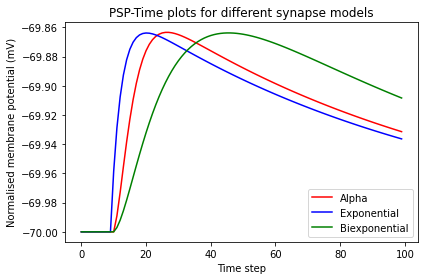

In [535]:
### PSP-Time plots for different synapse models

# Verifying synapse properties with no background noise and a single input spike
s_in = np.zeros((1, 100)) # duration 10ms
s_in[0, 10] = 1 # single input spike at time t=1ms
v_ALPHA, s_ALPHA, current_ALPHA = simulate_layer_ALPHA(spikes_in=s_in, noise=False, delay=0)
v_EXPONENTIAL, s_EXPONENTIAL, current_EXPONENTIAL = simulate_layer_EXPONENTIAL(spikes_in=s_in, noise=False, delay=0)
v_BIEXPONENTIAL, s_BIEXPONENTIAL, current_BIEXPONENTIAL = simulate_layer_BIEXPONENTIAL(spikes_in=s_in, noise=False, delay=0)
plt.figure()
plt.plot(v_ALPHA[0, :], 'r', label='Alpha')
plt.plot(v_EXPONENTIAL[0, :], 'b', label='Exponential')
plt.plot(v_BIEXPONENTIAL[0, :], 'g', label='Biexponential')
plt.xlabel('Time step')
plt.ylabel('Normalised membrane potential (mV)')
plt.title('PSP-Time plots for different synapse models')
plt.tight_layout();
plt.legend()

print('Alpha PSP verification')
print(f'  Maximum of PSP is {v_ALPHA.max():.4f} mV and should be -69.86 mV') 
print(f'  Maximum is attained at time {(v_ALPHA.argmax()-10)*0.1:.2f} ms and should be 1.7 ms')
print()
print('Exponential PSP verification')
print(f'  Maximum of PSP is {v_EXPONENTIAL.max():.4f} mV and should be -69.86 mV') 
print(f'  Maximum is attained at time {(v_EXPONENTIAL.argmax()-10)*0.1:.2f} ms and should be 1.7 ms')
print()
print('Biexponential PSP verification')
print(f'  Maximum of PSP is {v_BIEXPONENTIAL.max():.4f} mV and should be -69.86 mV')
print(f'  Maximum is attained at time {(v_BIEXPONENTIAL.argmax()-10)*0.1:.2f} ms and should be 1.7 ms')
print()

#### __(2.2) PSC-Time graphs for each synapse model__

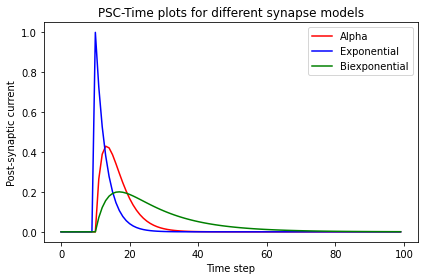

In [537]:
### PSC-Time plots for different synapse models

# Verifying synapse properties with no background noise and a single input spike
s_in = np.zeros((1, 100)) # duration 10ms
s_in[0, 10] = 1 # single input spike at time t=1ms
v_ALPHA, s_ALPHA, current_ALPHA = simulate_layer_ALPHA(spikes_in=s_in, noise=False, delay=0)
v_EXPONENTIAL, s_EXPONENTIAL, current_EXPONENTIAL = simulate_layer_EXPONENTIAL(spikes_in=s_in, noise=False, delay=0)
v_BIEXPONENTIAL, s_BIEXPONENTIAL, current_BIEXPONENTIAL = simulate_layer_BIEXPONENTIAL(spikes_in=s_in, noise=False, delay=0)
plt.figure()
plt.plot(current_ALPHA, 'r', label='Alpha')
plt.plot(current_EXPONENTIAL, 'b', label='Exponential')
plt.plot(current_BIEXPONENTIAL, 'g', label='Biexponential')
plt.xlabel('Time step')
plt.ylabel('Post-synaptic current')
plt.title('PSC-Time plots for different synapse models')
plt.legend()
plt.tight_layout();

#### __(3) Background noise validation__

Verification that, in the absence of any input spikes, the neurons in the network fire noise spikes at approximately the rate given in the paper, and that the mean and standard deviation of the membrane potential is as given in the paper. This verification is conducted on all 3 synapse models.

Background firing rate verification (ALPHA)
  Mean rate is 2.0 Hz, should be approximately 2 Hz
  Membrane potential mean is -62.30, should be approximately -61.75 mV
  Membrane potential std is 2.85, should be approximately 2.85 mV

Background firing rate verification (EXPONENTIAL)
  Mean rate is 1.9 Hz, should be approximately 2 Hz
  Membrane potential mean is -62.48, should be approximately -61.75 mV
  Membrane potential std is 2.79, should be approximately 2.85 mV

Background firing rate verification (BIEXPONENTIAL)
  Mean rate is 6.1 Hz, should be approximately 2 Hz
  Membrane potential mean is -61.67, should be approximately -61.75 mV
  Membrane potential std is 3.23, should be approximately 2.85 mV


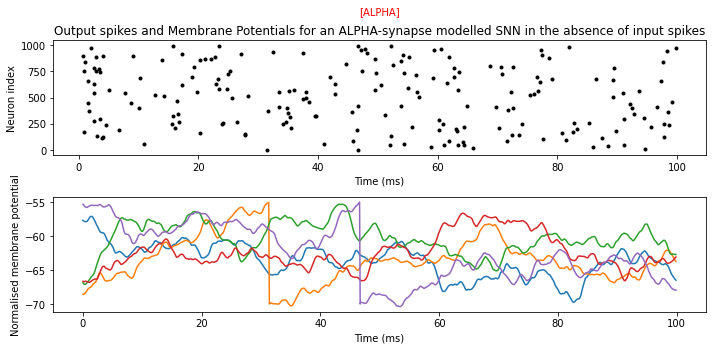

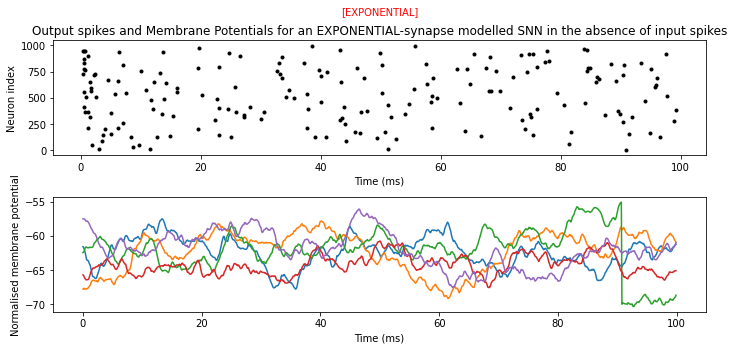

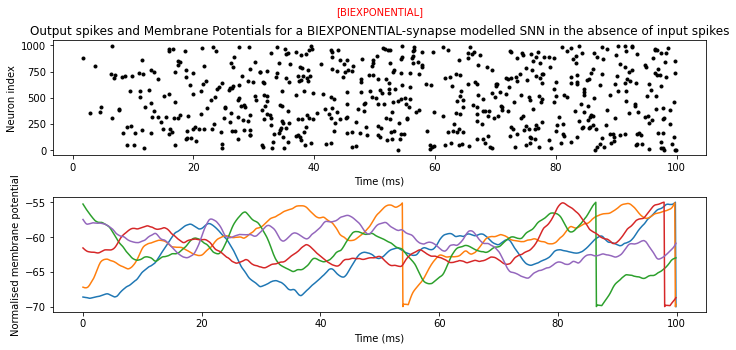

In [538]:
# Verify background noise gives appropriate level of output noise
v_ALPHA, s_ALPHA, current_ALPHA = simulate_layer_ALPHA(num_neurons=1000, num_time_steps=1000)
v_EXPONENTIAL, s_EXPONENTIAL, current_EXPONENTIAL = simulate_layer_EXPONENTIAL(num_neurons=1000, num_time_steps=1000)
v_BIEXPONENTIAL, s_BIEXPONENTIAL, current_BIEXPONENTIAL = simulate_layer_BIEXPONENTIAL(num_neurons=1000, num_time_steps=1000)

i_ALPHA, t_ALPHA = s_ALPHA.nonzero()
t_ALPHA = t_ALPHA*0.1 # dt

i_EXPONENTIAL, t_EXPONENTIAL = s_EXPONENTIAL.nonzero()
t_EXPONENTIAL = t_EXPONENTIAL*0.1 # dt

i_BIEXPONENTIAL, t_BIEXPONENTIAL = s_BIEXPONENTIAL.nonzero()
t_BIEXPONENTIAL = t_BIEXPONENTIAL*0.1 # dt


### ALPHA
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(t_ALPHA, i_ALPHA, '.k')
plt.title('Output spikes and Membrane Potentials for an ALPHA-synapse modelled SNN in the absence of input spikes')
plt.text(0.5, 1.25, '[ALPHA]', ha='center', va='center', transform=plt.gca().transAxes, color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(212)
plt.plot(np.arange(1000)*0.1, v_ALPHA[:5, :1000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()

print('Background firing rate verification (ALPHA)')
print(f'  Mean rate is {s_ALPHA.sum() / (1000 * 1000 * 0.1 * 1e-3):.1f} Hz, should be approximately 2 Hz')
print(f'  Membrane potential mean is {v_ALPHA.mean():.2f}, should be approximately -61.75 mV')
print(f'  Membrane potential std is {v_ALPHA.std():.2f}, should be approximately 2.85 mV')

### EXPONENTIAL
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(t_EXPONENTIAL, i_EXPONENTIAL, '.k')
plt.title('Output spikes and Membrane Potentials for an EXPONENTIAL-synapse modelled SNN in the absence of input spikes')
plt.text(0.5, 1.25, '[EXPONENTIAL]', ha='center', va='center', transform=plt.gca().transAxes, color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(212)
plt.plot(np.arange(1000)*0.1, v_EXPONENTIAL[:5, :1000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()

print('\nBackground firing rate verification (EXPONENTIAL)')
print(f'  Mean rate is {s_EXPONENTIAL.sum() / (1000 * 1000 * 0.1 * 1e-3):.1f} Hz, should be approximately 2 Hz')
print(f'  Membrane potential mean is {v_EXPONENTIAL.mean():.2f}, should be approximately -61.75 mV')
print(f'  Membrane potential std is {v_EXPONENTIAL.std():.2f}, should be approximately 2.85 mV')

### BIEXPONENTIAL
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(t_BIEXPONENTIAL, i_BIEXPONENTIAL, '.k')
plt.title('Output spikes and Membrane Potentials for a BIEXPONENTIAL-synapse modelled SNN in the absence of input spikes')
plt.text(0.5, 1.25, '[BIEXPONENTIAL]', ha='center', va='center', transform=plt.gca().transAxes, color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(212)
plt.plot(np.arange(1000)*0.1, v_BIEXPONENTIAL[:5, :1000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()

print('\nBackground firing rate verification (BIEXPONENTIAL)')
print(f'  Mean rate is {s_BIEXPONENTIAL.sum() / (1000 * 1000 * 0.1 * 1e-3):.1f} Hz, should be approximately 2 Hz')
print(f'  Membrane potential mean is {v_BIEXPONENTIAL.mean():.2f}, should be approximately -61.75 mV')
print(f'  Membrane potential std is {v_BIEXPONENTIAL.std():.2f}, should be approximately 2.85 mV')

#### __(4) Raster scans of propagating spike volley along fully connected synfire chain__

Here, we aim to observe the propagation of synchronous spiking with a constant delay and how each neuron group behaves after receiving an input spike burst. The test is conducted on each of the 3 synapse models and the resultant Raster scans are used for comparison.

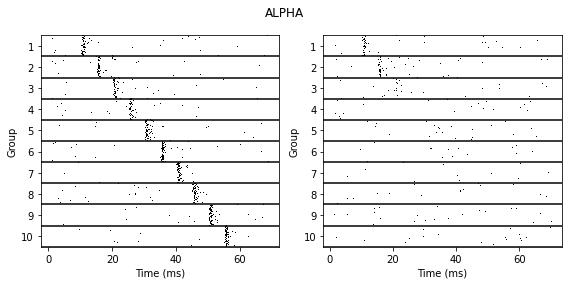

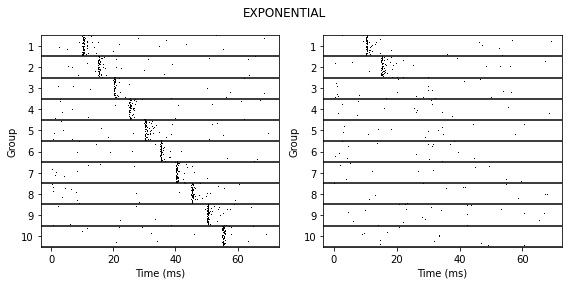

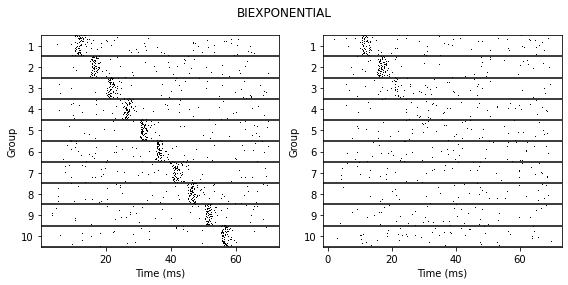

In [539]:
### ALPHA

num_neurons = 100
a_values = [50, 48]
delay = 50

plt.figure(figsize=(8, 4))
for plotidx, a in enumerate(a_values):
        
    s = input_burst(num_neurons=num_neurons, num_active=a, offset=delay)

    plt.subplot(1, 2, plotidx+1)
    
    
    for layer in range(10):
        if layer == 0:
            s_accumulated = all_to_all(s)
            
        else:

            if plotidx == 0:
                num_of_spikes = s_accumulated[0][delay*(layer)]

                s_accumulated[:, delay*(layer)] = 0
                s_accumulated[:, :delay*layer] = 0
                s_accumulated[:, delay*(layer+1):] = 0
                s_accumulated[:, delay*(layer+1)] = num_of_spikes
            else:
                num_of_spikes = s_accumulated[0][delay*(layer)]
                index = delay * (layer + 1)
                std_dev = 1  # Standard deviation of the normal distribution
                # The degree of temporal accuracy of spike times among the group's members determines whether subsequent groups can reproduce 
                # (or even improve) this accuracy (Fig. 1d), or whether synchronous excitation disperses and eventually dies out (Fig. 1e). 
                # Generate random indices around `index` using normal distribution
                if num_of_spikes <=0:
                    num_of_spikes =0
                
                random_indices = np.random.normal(loc=index, scale=std_dev, size=int(num_of_spikes)).astype(int)
                s_accumulated[:, delay*(layer)] = 0
                s_accumulated[:, :delay*layer] = 0
                s_accumulated[:, delay*(layer+1):] = 0
                # Update values in s_accumulated
                for i in random_indices:
                    if 0 <= i < s_accumulated.shape[1]:
                        s_accumulated[:, i] += 1
                
        _, s, __ = simulate_layer_ALPHA(spikes_in=s_accumulated)
        i, t = s.nonzero()
        plt.plot(t*0.1, i/100+9-layer, ',k')
        plt.axhline(layer, c='k')
    plt.ylim(0, 10)
    plt.yticks(np.arange(10)+0.5, np.arange(1, 11)[::-1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Group')
plt.suptitle('ALPHA')
plt.tight_layout();

### EXPONENTIAL

plt.figure(figsize=(8, 4))
for plotidx, a in enumerate(a_values):
        
    s = input_burst(num_neurons=num_neurons, num_active=a, offset=delay)

    plt.subplot(1, 2, plotidx+1)
    
    
    for layer in range(10):
        if layer == 0:
            s_accumulated = all_to_all(s)
            
        else:

            if plotidx == 0:
                num_of_spikes = s_accumulated[0][delay*(layer)]

                s_accumulated[:, delay*(layer)] = 0
                s_accumulated[:, :delay*layer] = 0
                s_accumulated[:, delay*(layer+1):] = 0
                s_accumulated[:, delay*(layer+1)] = num_of_spikes
            else:
                num_of_spikes = s_accumulated[0][delay*(layer)]
                index = delay * (layer + 1)
                std_dev = 1  # Standard deviation of the normal distribution
                # The degree of temporal accuracy of spike times among the group's members determines whether subsequent groups can reproduce 
                # (or even improve) this accuracy (Fig. 1d), or whether synchronous excitation disperses and eventually dies out (Fig. 1e). 
                # Generate random indices around `index` using normal distribution
                if num_of_spikes <=0:
                    num_of_spikes =0
                
                random_indices = np.random.normal(loc=index, scale=std_dev, size=int(num_of_spikes)).astype(int)
                s_accumulated[:, delay*(layer)] = 0
                s_accumulated[:, :delay*layer] = 0
                s_accumulated[:, delay*(layer+1):] = 0
                # Update values in s_accumulated
                for i in random_indices:
                    if 0 <= i < s_accumulated.shape[1]:
                        s_accumulated[:, i] += 1
                
        _, s, __ = simulate_layer_EXPONENTIAL(spikes_in=s_accumulated)
        i, t = s.nonzero()
        plt.plot(t*0.1, i/100+9-layer, ',k')
        plt.axhline(layer, c='k')
    plt.ylim(0, 10)
    plt.yticks(np.arange(10)+0.5, np.arange(1, 11)[::-1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Group')
plt.suptitle('EXPONENTIAL')
plt.tight_layout();

### BIEXPONENTIAL

plt.figure(figsize=(8, 4))
for plotidx, a in enumerate(a_values):
        
    s = input_burst(num_neurons=num_neurons, num_active=a, offset=delay)

    plt.subplot(1, 2, plotidx+1)
    
    
    for layer in range(10):
        if layer == 0:
            s_accumulated = all_to_all(s)
            
        else:

            if plotidx == 0:
                num_of_spikes = s_accumulated[0][delay*(layer)]

                s_accumulated[:, delay*(layer)] = 0
                s_accumulated[:, :delay*layer] = 0
                s_accumulated[:, delay*(layer+1):] = 0
                s_accumulated[:, delay*(layer+1)] = num_of_spikes
            else:
                num_of_spikes = s_accumulated[0][delay*(layer)]
                index = delay * (layer + 1)
                std_dev = 1  # Standard deviation of the normal distribution
                # The degree of temporal accuracy of spike times among the group's members determines whether subsequent groups can reproduce 
                # (or even improve) this accuracy (Fig. 1d), or whether synchronous excitation disperses and eventually dies out (Fig. 1e). 
                # Generate random indices around `index` using normal distribution
                if num_of_spikes <=0:
                    num_of_spikes =0
                
                random_indices = np.random.normal(loc=index, scale=std_dev, size=int(num_of_spikes)).astype(int)
                s_accumulated[:, delay*(layer)] = 0
                s_accumulated[:, :delay*layer] = 0
                s_accumulated[:, delay*(layer+1):] = 0
                # Update values in s_accumulated
                for i in random_indices:
                    if 0 <= i < s_accumulated.shape[1]:
                        s_accumulated[:, i] += 1
                
        _, s, __ = simulate_layer_BIEXPONENTIAL(spikes_in=s_accumulated)
        i, t = s.nonzero()
        plt.plot(t*0.1, i/100+9-layer, ',k')
        plt.axhline(layer, c='k')
    plt.ylim(0, 10)
    plt.yticks(np.arange(10)+0.5, np.arange(1, 11)[::-1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Group')
plt.suptitle('BIEXPONENTIAL')
plt.tight_layout();



#### __(5) $\alpha - a_{in}$ and $\sigma_{in} - \sigma_{out}$ graphs__

Here, we follow the paper's methodology in characterising a spike volley through a "pulse packet", which has parameters $a$ and $\sigma$.

$a$ is defined as the "activity" or the number of spikes in the volley and, in this section, we aim to find the relationship between $a_{in}$, the number of input spikes, and $\alpha$, the spike probability.

We also investigate $\sigma$, the temporal dispersion (which the paper's approach measures by the standard deviation of the underlying pulse density), and aim to find the relationship between $\sigma_{in}$ and $\sigma_{out}$. This gives the relation between temporal accuracy of spike response versus input synchrony.

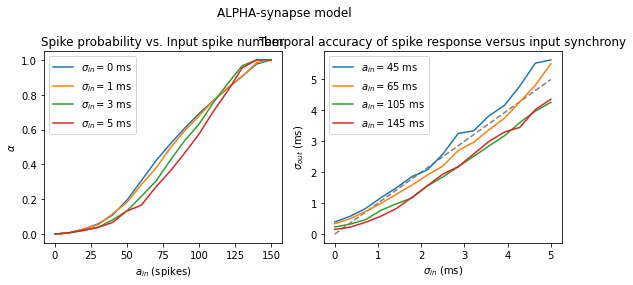

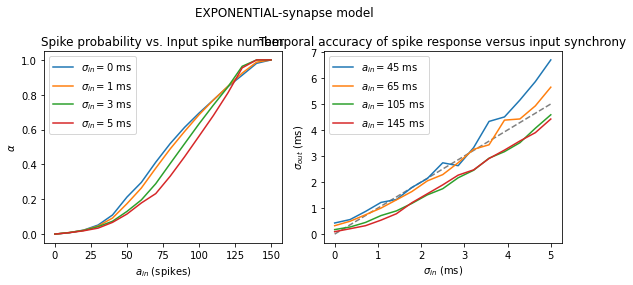

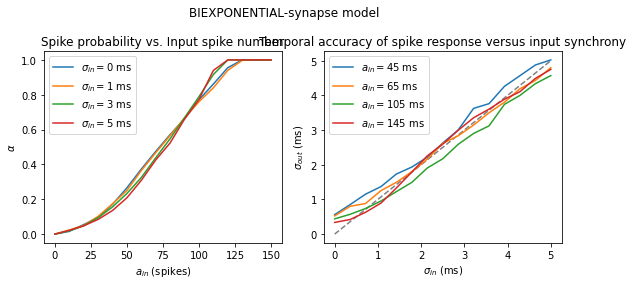

In [542]:
def neural_transmission_CustomSynapse(a_in, sigma_in, repeats=20, dt=0.1, synapse='alpha'):
    time_steps = int(repeats/dt)
    alpha_sum = 0
    sigma_out_sum = 0
    offset = 150

    for i in range(repeats):
        # We put in a burst of a_in spikes with spread sigma_in
        s = input_burst(num_neurons=a_in, num_active=a_in, offset=offset, sigma=(sigma_in), dt=dt, num_time_steps=400)

        s = all_to_all(s)
        # Run the simulation for one layer
        if synapse == 'alpha':
            _, s, __ = simulate_layer_ALPHA(num_neurons=150, spikes_in=s, noise=True, num_time_steps=400, delay=0)
        elif synapse == 'exponential':
            _, s, __ = simulate_layer_EXPONENTIAL(num_neurons=150, spikes_in=s, noise=True, num_time_steps=400, delay=0)
        elif synapse == 'biexponential':
            _, s, __ = simulate_layer_BIEXPONENTIAL(num_neurons=150, spikes_in=s, noise=True, num_time_steps=400, delay=0)

        alpha_temp, sigma_out_temp = estimate_pulse_parameters(s, 150, sigma_in, offset)
        alpha_sum += alpha_temp
        sigma_out_sum += sigma_out_temp
        
    alpha = alpha_sum/repeats
    sigma_out = sigma_out_sum/repeats
    return alpha, sigma_out

def plot_alpha_sigma(synapse='alpha'):
    plt.figure(figsize=(8, 4))
    ax1 = plt.subplot(121)
    for sigma in [0, 1, 3, 5]:
        A_IN = np.arange(0, 150+1, 10)
        ALPHA = [neural_transmission_CustomSynapse(a_in, sigma, synapse=synapse)[0] for a_in in A_IN]
        plt.plot(A_IN, ALPHA, label=f'$\\sigma_{{in}}={sigma}$ ms')
    # plt.xlabel(r'$a_{in}$ (spikes)')
    # plt.ylabel(r'$\alpha$')
    # plt.legend(loc='best')
    # plt.set_title('asdsadasd')
    ax1.set_xlabel(r'$a_{in}$ (spikes)')
    ax1.set_ylabel(r'$\alpha$')
    ax1.legend(loc='best')
    ax1.set_title('Spike probability vs. Input spike number', wrap=True)
    ax2 = plt.subplot(122)
    for a_in in [45, 65, 105, 145]:
        SIGMA_IN = np.linspace(0, 5, 15)
        SIGMA_OUT = [neural_transmission_CustomSynapse(a_in, sigma_in, synapse=synapse)[1] for sigma_in in SIGMA_IN]
        plt.plot(SIGMA_IN, SIGMA_OUT, label=f'$a_{{in}}={a_in}$ ms')
    # plt.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
    # plt.xlabel(r'$\sigma_{in}$ (ms)')
    # plt.ylabel(r'$\sigma_{out}$ (ms)')
    # plt.legend(loc='best')
    # plt.set_title('asdsadasd')
    ax2.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
    ax2.set_xlabel(r'$\sigma_{in}$ (ms)')
    ax2.set_ylabel(r'$\sigma_{out}$ (ms)')
    ax2.legend(loc='best')
    ax2.set_title('Temporal accuracy of spike response versus input synchrony', wrap=True)

    plt.suptitle(synapse.upper() + '-synapse model')
    plt.tight_layout();

plot_alpha_sigma(synapse='alpha')
plot_alpha_sigma(synapse='exponential')
plot_alpha_sigma(synapse='biexponential')

#### __(6) $(a, \sigma)$ State space portrait & trajectories.__

This section aims to conduct a state-space analysis of propagating spike synchrony, as done in the paper. This is done by tracking the trajectory of evolution of a given pulse packet $(a, \sigma)$ through iterative stages.

Convergence/divergence behaviour in the state space analysis provides insight on the SNN's stability and sensitivity.

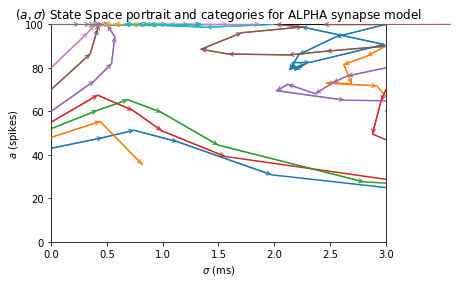

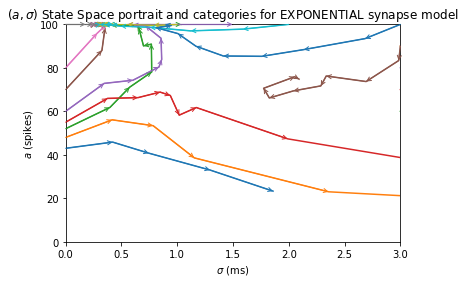

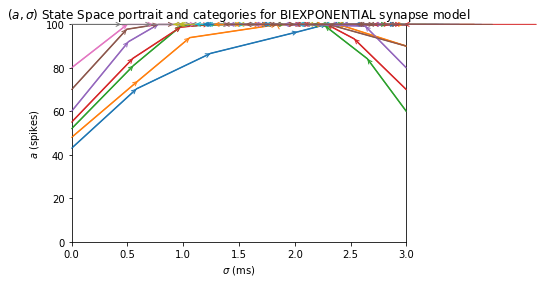

In [543]:
def plot_trajectories(synapse='alpha'):
    starting_points = [
        (43, 0), (48, 0), (52, 0), (55, 0), (60, 0), (70, 0), (80, 0), (100, 0), (100, 1), (100, 2), (100, 3), (90, 3), (60, 3), (70, 3), (80, 3), (90, 3)
        ]
    repeats = 20
    dt = 0.1
    offset = 100
    num_neurons = 100

    plt.figure()

    for idx, (a, sigma) in enumerate(starting_points):
        A, SIGMA = [a], [sigma]
        s = input_burst(num_neurons=100, num_active=a, offset=offset, sigma=(sigma), dt=dt, num_time_steps=400)

        for _ in range(10):

            a_sum = 0
            sigma_sum = 0
            A.append(a)
            SIGMA.append(sigma)

            for i in range(repeats):

                s_1 = all_to_all(s)
                if synapse=='alpha':
                    _, s_1, __ = simulate_layer_ALPHA(num_neurons=num_neurons, spikes_in=s_1, noise=True, num_time_steps=400, delay=0)
                elif synapse == 'exponential':
                    _, s_1, __ = simulate_layer_EXPONENTIAL(num_neurons=num_neurons, spikes_in=s_1, noise=True, num_time_steps=400, delay=0)
                elif synapse == 'biexponential':
                    _, s_1, __ = simulate_layer_BIEXPONENTIAL(num_neurons=num_neurons, spikes_in=s_1, noise=True, num_time_steps=400, delay=0)
                alpha_temp, sigma_temp = estimate_pulse_parameters(s_1, num_neurons, sigma, offset)
                a_temp = int(alpha_temp*num_neurons)
                a_sum += a_temp
                sigma_sum += sigma_temp
            
            s = s_1

            a = a_sum / repeats
            sigma = sigma_sum / repeats
            
        plt.plot(SIGMA, A, c=f'C{idx}')
        for i in range(len(SIGMA)-1):
            plt.annotate('', (SIGMA[i+1], A[i+1]), xytext=(SIGMA[i], A[i]), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, color=f'C{idx}'))
    plt.xlim(0, 3)
    plt.ylim(0, 100)
    plt.xlabel(r'$\sigma$ (ms)')
    plt.ylabel('$a$ (spikes)')
    if synapse=='alpha':
        plt.title('$(a, \sigma)$ State Space portrait and categories for ALPHA synapse model')
    elif synapse == 'exponential':
        plt.title('$(a, \sigma)$ State Space portrait and categories for EXPONENTIAL synapse model')
    elif synapse == 'biexponential':
        plt.title('$(a, \sigma)$ State Space portrait and categories for BIEXPONENTIAL synapse model')
    # plt.tight_layout();

plot_trajectories(synapse='alpha')
plot_trajectories(synapse='exponential')
plot_trajectories(synapse='biexponential')